In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)
import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from utils import * # We've added all the functions from the last BLU to the utils.py 

# General

- The data is actually from a recent competition: [HYBRID ENERGY FORECASTING AND TRADING COMPETITION](https://ieee-dataport.org/competitions/hybrid-energy-forecasting-and-trading-competition)
- My solution focuses on ML because in my experience it tipically beats SARIMAX approaches specially in use cases which are highly dependendant on exogenous data.

# DATA

- It's essential to do build_exog_features. If not, you will only send the exogenous forecast for the timestamp in which you're doing the prediction, instead of the timestamps that you are forecasting.
- There are some missing_values, but our ML functions on the utils already drop them

In [112]:
df = pd.read_csv("data/data.csv", index_col="date", parse_dates=True)

In [53]:
df = build_exog_features(df, 24*7)

In [83]:
train = df.iloc[:-24*7*2]
val = df.iloc[-24*7*2:-24*7]
train_val = df.iloc[:-24*7]
test = df.iloc[-24*7:]

# BASELINE

- There is no weekly seasonality, so a simple baseline is the average production of the last day

In [109]:
baseline = [train.power.iloc[-24:].mean()] * len(val["power"])
val_mae = mean_absolute_error(val["power"], baseline)
print(val_mae)

339.8339007936508


In [110]:
val["predictions"] = baseline

<Axes: xlabel='date'>

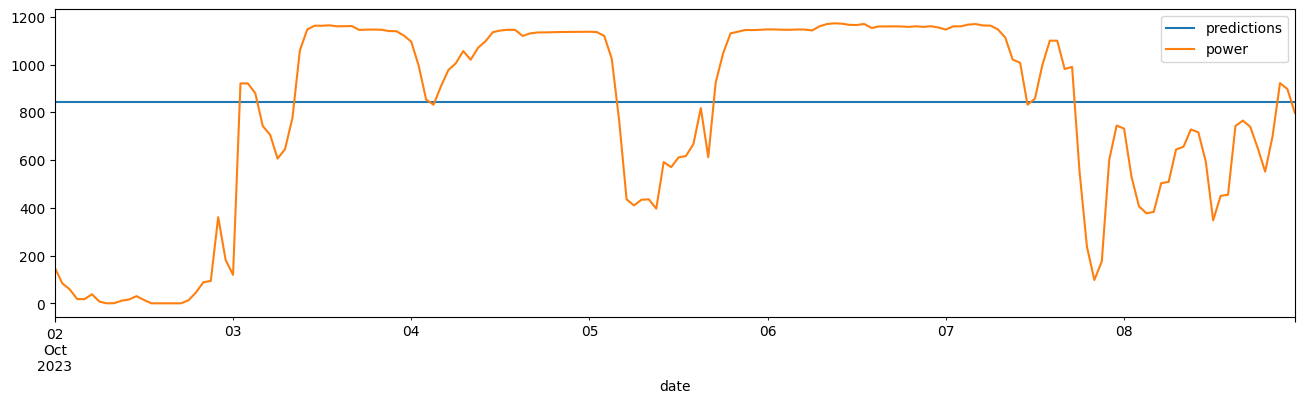

In [111]:
val[["predictions","power"]].plot()

# VALIDATION

- Holiday and weekday flags shouldn't matter much for wind production since it mostly depends on the weather

In [48]:
predictions = predict_n_periods(series_=train, 
                  n_periods=24*7, 
                  model=LinearRegression(), 
                  num_periods_lagged=24*3,
                  num_periods_diffed=0,
                  weekday = False,
                  month = True,
                  holidays = False,
                  target = "power"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

In [49]:
val_mae = mean_absolute_error(val["power"],predictions)
print(val_mae)

183.61981947955488


In [50]:
val["predictions"] = predictions

<Axes: xlabel='date'>

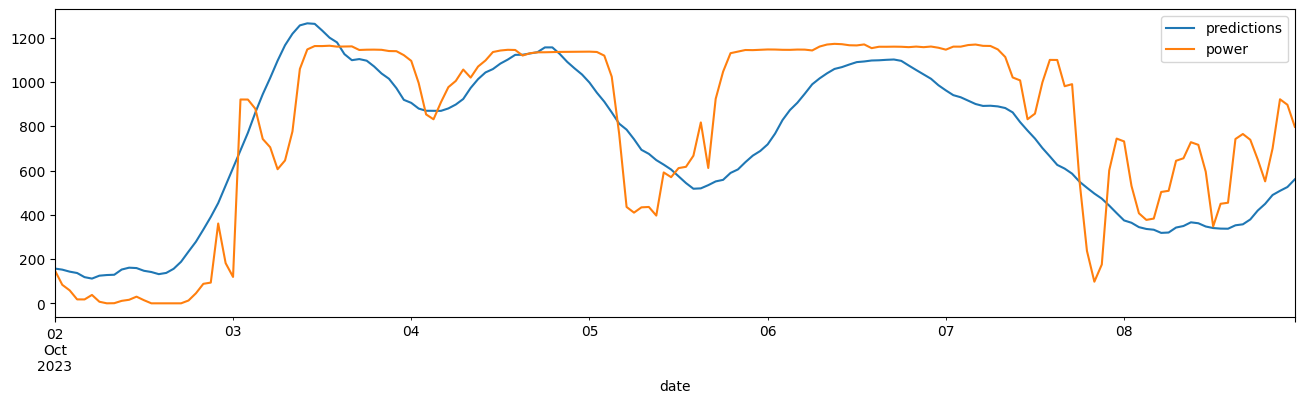

In [51]:
val[["predictions","power"]].plot()

# TEST

In [102]:
predictions = predict_n_periods(series_=train_val, 
                  n_periods=24*7, 
                  model=LinearRegression(), 
                  num_periods_lagged=24*3,
                  num_periods_diffed=0,
                   weekday = False,
                  month = True,
                  holidays = False,
                  target = "power"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

In [103]:
output = pd.Series(predictions, name="power")

In [104]:
output.to_csv("predictions.csv", index=False)

# NEXT STEPS

- Perform Time Series Cross Validation. We're evaluating on just one week which isn't a great evaluation of how well the model performs. 
- Do hyperparameter tuning exploring more complex models such as gradient boosting and random forests.
- Implement a SARIMAX-based approach and if it has similar level of performance make an ensemble out of the two.